In [1]:
%pylab inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar
from scipy import math
import pylandau
import random

Populating the interactive namespace from numpy and matplotlib


# Importo il dataset

In [2]:
file = pd.read_csv(r'/home/gdeandrea/Scrivania/UNI/Econofisica/MyModels/Epstein/PRESE DATI/A-Valore Soglia/dati_rivolte')
file.head()

,x,y,color,pen down?,x.1,y.1,color.1,pen down?.1,x.2,y.2,color.2,pen down?.2
0,0,1120,55,True,0,0,0,True,0,0,15,True
1,1,1076,55,True,1,7,0,True,1,37,15,True
2,2,868,55,True,2,53,0,True,2,199,15,True
3,3,626,55,True,3,111,0,True,3,383,15,True
4,4,611,55,True,4,167,0,True,4,342,15,True


In [3]:
df = file['y.2']
y = df.to_numpy()
x = ar(range(len(y)))

# Definizioni Utili

## Fit Utils

In [45]:
def chiquadronorm(oss, fit, sigma, ddof, aiuto=False, norm=True):
    'funzione che calcola il chiquadrato di una distribuzione osservata rispetto a una\
    forma funzionale nota'
    
    #prende liste monodimensionali come argomenti
    scarti = []
    scartiquadri = []
    scartiquadridivisi = []
    
    for i in range(len(oss)):
        scarti.append(oss[i]-fit[i])
        scartiquadri.append(scarti[i]*scarti[i])
        scartiquadridivisi.append(scartiquadri[i]/(sigma[i]*sigma[i]))
        
        if (aiuto==True):
            print('scarti= ', scarti[i])
            print('scartiquadri= ', scartiquadri[i])
            print('scartiquadridivisi= ', scartiquadridivisi[i])
            
    chiquadro=sum(scartiquadridivisi)
    chiquadroreg=chiquadro/ddof
    
    if(norm==True):
        return (chiquadroreg)
    else:
        return (chiquadro)

def media_pesata(x, sigma):
    numeratore = 0
    denominatore = 0
    for i in range(len(x)):
        numeratore += x[i]/(sigma[i]**2)
        denominatore += 1/(sigma[i]**2)
    return numeratore/denominatore
    
def retta(x,m,q):
    return m*x +q

def gauss(x,a,x0,sigma,baseline):
    'Ritorna array gaussiano a partire da lista x secondo i parametri a,x0,sigma'
    return (baseline + a*exp(-(x-x0)**2/(2*sigma*sigma)))


def lore(x, a, x0, y0, baseline):
    'Ritorna array lorentziano a partire da lista x secondo i parametri a,x0,yo'
    return (baseline + a*(y0/(((x - x0)**2) + (y0**2))))

def fattoriale(x):
    temp_list = []

    for ics in x:
        f=1
        for i in range(1,ics+1):
            f*=i
        temp_list.append(f)
    return(temp_list)

def poisson(x, a, media, baseline):
    result = baseline + a*(media**x)*np.exp(-media)/fattoriale(x)
    return(result)

def landau(x, mpv, eta, A, baseline):
    x=double(x)
    'Ritorna array landauiano a partire da lista x secondo i parametri suoi'
    return (baseline + double(pylandau.landau(x, mpv=mpv, eta=eta, A=A)))

## Selecting Spikes

In [5]:
def isola_spikes (y, datiesterni):
    
    rivolte_diz = {}
    temp_rivolta_list = []
    rivolte_counter = 0
    cerarivolta = False
    
    for i in range(len(y)):
        
        ##aggiustato a 12 per non avere rivoltini
        if y[i] > 12:
            temp_rivolta_list.append(y[i])
            if cerarivolta == False:
                rivolte_counter += 1
                cerarivolta = True
        else:
            if cerarivolta == True:
                lunghezza=len(temp_rivolta_list)
                if rivolte_counter > 1:
                    if datiesterni == 1:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                    if datiesterni == 2:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_rivolta_list.insert(0, y[i-lunghezza-2])
                    if datiesterni == 3:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_rivolta_list.insert(0, y[i-lunghezza-2])
                        temp_rivolta_list.insert(0, y[i-lunghezza-3])
                else:
                    if datiesterni == 1:
                        temp_rivolta_list.insert(0, 0)
                    if datiesterni == 2:
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                    if datiesterni == 3:
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                    
                if datiesterni == 1:
                        temp_rivolta_list.append(y[i])
                if datiesterni == 2:
                        temp_rivolta_list.append(y[i])
                        temp_rivolta_list.append(y[i+1])
                if datiesterni == 3:
                        temp_rivolta_list.append(y[i])
                        temp_rivolta_list.append(y[i+1])
                        temp_rivolta_list.append(y[i+2])
                
                rivolte_diz[str(rivolte_counter)+'_rivolta'] = temp_rivolta_list
                temp_rivolta_list = []
                cerarivolta = False
                
    return rivolte_diz

# Analisi

## Creo dizionario delle rivolte

In [6]:
rivolte_dict = isola_spikes(y, 3)

## Seleziono N spikes a caso

In [7]:
N = 5
choosen_list = random.sample(list(rivolte_dict.keys()), k=N)
choosen_list

['13_rivolta', '5_rivolta', '9_rivolta', '12_rivolta', '3_rivolta']

In [8]:
bellerivolte = ['5_rivolta', '15_rivolta', '3_rivolta', '7_rivolta', '18_rivolta']

In [9]:
choosen_list = bellerivolte

## Fit Gauss&Lore con Chiqudrati

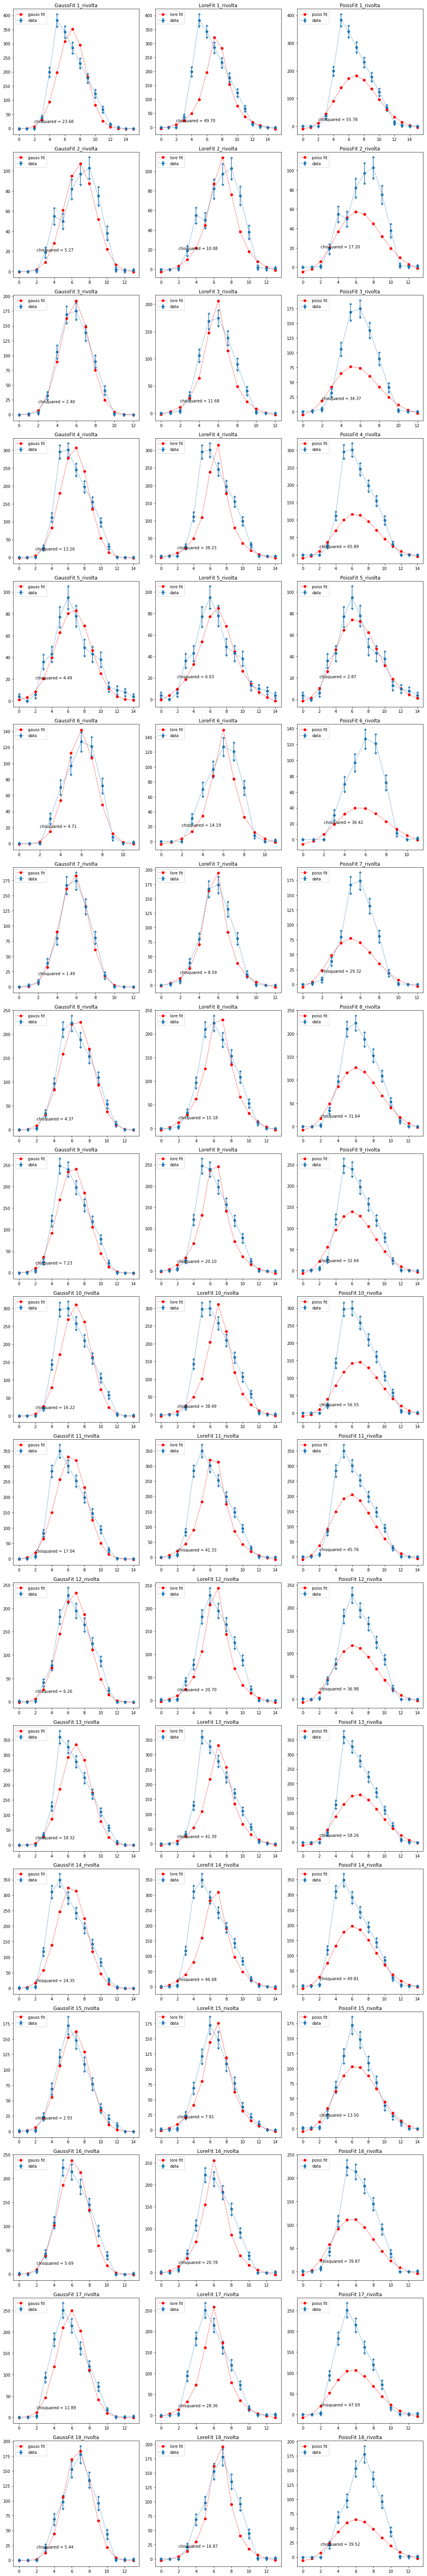

In [20]:
fig, ax = plt.subplots(nrows=len(rivolte_dict.keys()), ncols=3, figsize=(15,90))

gauss_chisq_list = []
lore_chisq_list = []
poiss_chisq_list = []

for i, rivolta in enumerate(rivolte_dict.keys()):
    
    y = rivolte_dict[rivolta]
    x = range(len(y))
    ##computo errore come radice dei conteggi
    sigma_gauss = np.where(np.sqrt(y)==0,1,np.sqrt(y))
    ##computo errore come larghezza a metà altezza
    #sigma_gauss = 2*sqrt(np.abs(gauss_params[2]*gauss_params[2]*2*log(2)))
    gauss_params,gauss_cov = curve_fit(gauss,x,y,p0=[200.,3.,2.5,0],sigma=sigma_gauss)
    gauss_red_chisq = chiquadronorm(y, gauss(x,*gauss_params), sigma_gauss, len(y)-len(gauss_params), norm=True)
    gauss_chisq_list.append(gauss_red_chisq)
    #print('amplitude:', gauss_params[0])
    #print('mean:', gauss_params[1])
    #print('sigma:', gauss_params[2])
    #print('baseline: ', gauss_params[3])
    #print('errore: ', sigma_gauss)
    
    sigma_lore = sigma_gauss
    lore_params,lore_cov = curve_fit(lore,x,y,p0=[-500.,3.,-2.,-30.],sigma=sigma_gauss)
    lore_red_chisq = chiquadronorm(y, lore(x,*lore_params), sigma_lore, len(y)-len(lore_params), norm=True)
    lore_chisq_list.append(lore_red_chisq)
    #print('amplitude:', lore_params[0])
    #print('mean:', lore_params[1])
    #print('y0:', lore_params[2])
    #print('baseline:', lore_params[3])
    #print('errore: ', sigma_lore)
    
    sigma_poiss = sigma_gauss 
    poiss_params,poiss_cov = curve_fit(poisson,x,y, p0=[400.,3.,0], sigma=sigma_poiss)
    poiss_red_chisq = chiquadronorm(y, poisson(x, *poiss_params), sigma_poiss, len(y)-len(poiss_params), norm=True)
    poiss_chisq_list.append(poiss_red_chisq)
    #print('amplitude:', poiss_params[0])
    #print('mean:', poiss_params[1])
    #print('errore: ', sigma_poiss)
    
    #landau_params, landau_cov = curve_fit(landau, x, y, p0=[3,5,100,0], sigma=sigma_gauss)
    #landau_red_chisq = chiquadronorm(y, landau(x,*landau_params), sigma_gauss, len(y)-len(landau_params), norm=True)
    
    x_cont = np.linspace(x[0], x[-1], 100)
    
    ax[i][0].errorbar(x,y,yerr=np.sqrt(y),fmt='o:',uplims=True, lolims=True,label='data')
    ax[i][0].plot(x,gauss(x,*gauss_params),'ro:',label='gauss fit')
    ax[i][0].legend(loc='upper left')
    ax[i][0].text(2,20,'chisquared = %.2f' % (gauss_red_chisq))
    ax[i][0].title.set_text('GaussFit ' + rivolta)
    
    ax[i][1].errorbar(x,y,yerr=np.sqrt(y),fmt='o:',uplims=True, lolims=True,label='data')
    ax[i][1].plot(x,lore(x,*lore_params),'ro:',label='lore fit')
    ax[i][1].legend(loc='upper left')
    ax[i][1].text(2,20,'chisquared = %.2f' % (lore_red_chisq))
    ax[i][1].title.set_text('LoreFit ' + rivolta)
    
    ax[i][2].errorbar(x,y,yerr=np.sqrt(y),fmt='o:',uplims=True, lolims=True,label='data')
    ax[i][2].plot(x,poisson(x,*poiss_params),'ro:',label='poiss fit')
    ax[i][2].legend(loc='upper left')
    ax[i][2].text(2,20,'chisquared = %.2f' % (poiss_red_chisq))
    ax[i][2].title.set_text('PoissFit ' + rivolta)
    
    #ax[i][3].plot(x,y,'b+:',label='data')
    #ax[i][3].plot(x,landau(x,*landau_params),'ro:',label='landa fit')
    #ax[i][3].legend(loc='upper left')
    #ax[i][3].text(2,20,'chisquared = %.2f' % (landau_red_chisq))
    #ax[i][3].title.set_text('LandaFit ' + rivolta)

fig.tight_layout()
plt.show()

**What's the best function in depicting data?**

In [21]:
## Printing how many times each function had the best chi squared
gauss_score = 0
lore_score = 0
poiss_score = 0
for i in range(len(gauss_chisq_list)):
    if gauss_chisq_list[i] < lore_chisq_list[i] and gauss_chisq_list[i] < poiss_chisq_list[i]:
        gauss_score+=1
    elif lore_chisq_list[i] < poiss_chisq_list[i]:
        lore_score+=1
    else:
        poiss_score+=1
        
print('Gauss %score:', gauss_score/len(gauss_chisq_list))
print('Lore %score:', lore_score/len(lore_chisq_list))
print('Poiss %score:', poiss_score/len(poiss_chisq_list))

Gauss %score: 0.9444444444444444
Lore %score: 0.0
Poiss %score: 0.05555555555555555


In [22]:
np.argmax(gauss_chisq_list)

13

In [23]:
np.argmin(poiss_chisq_list)

4

# Valore Soglia  
**HP: sono funzioni gaussiane**

In [55]:
##calcolo soglie come f(media-sigma) e errore come f(media-1.2*sigma)-f(media-0.8*sigma)
soglie = []
err_soglie = []
for i, rivolta in enumerate(rivolte_dict.keys()):
    
    y = rivolte_dict[rivolta]
    x = range(len(y))
    ##computo errore come radice dei conteggi
    sigma_gauss = np.where(np.sqrt(y)==0,1,np.sqrt(y))
    
    gauss_params,gauss_cov = curve_fit(gauss,x,y,p0=[200.,3.,2.5,0],sigma=sigma_gauss)
    gauss_red_chisq = chiquadronorm(y, gauss(x,*gauss_params), sigma_gauss, len(y)-len(gauss_params), norm=True)
    soglia = gauss(gauss_params[1] - gauss_params[2], *gauss_params)
    errore = gauss(gauss_params[1] - 1.2*gauss_params[2], *gauss_params) - gauss(gauss_params[1] - 0.8*gauss_params[2], *gauss_params)
    #print(gauss_params[-1])
    soglie.append(soglia)
    err_soglie.append(np.abs(errore))
soglie = soglie[5:]
err_soglie = err_soglie[5:]
#print(soglie)

## Metodo grafico

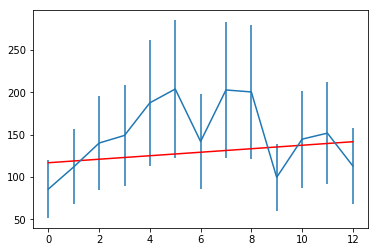

0.5087231759080189


In [60]:
popt, pcov = curve_fit(retta, range(len(soglie)), soglie, sigma=err_soglie)
retta_red_chisq = chiquadronorm(soglie, retta(range(len(soglie)),*popt), err_soglie, len(soglie)-len(popt), norm=True)
plt.plot(range(len(soglie)), retta(range(len(soglie)),*popt), color='r')
plt.errorbar(range(len(soglie)), soglie, yerr=err_soglie)
plt.show()
print('ReducedChiSquared:', retta_red_chisq)

**Pendenza compatibile con lo zero?**

In [62]:
pendenza = popt[0]

2.0671235222585893

In [72]:
err_pendenza = np.sqrt(pcov[0][0])
err_pendenza

2.4160387530636345

la pendenza trovata più il relativo errore comprende lo zero, allora la retta è compatibile con un valore costante  
**Le distribuzioni delle rivolte sono omogenee, i dati appartengono alla stessa distribuzione statistica**

## Metodo Analitico

In [63]:
np.mean(soglie)

148.61337626032457

In [64]:
media_pesata_soglie = media_pesata(soglie, err_soglie)
media_pesata_soglie

128.1241472701187

In [65]:
errore_media_soglia = np.sqrt(np.sum((soglie - media_pesata_soglie)**2)/(len(soglie)*(len(soglie)-1)))
errore_media_soglia

12.6007119219633

In [70]:
## Check: soglie calcolate per singole rivolte compatibili con media pesata
###ragionamento dietro implementazione:
###se la singola soglia è maggiore di media+errore_media_soglia 
###allora non voglio che soglia-errore_soglia sia maggiore di media+errore_media_soglia
###se la singola soglia è minore di media-errore_media_soglia 
###allora non voglio che soglia+errore_soglia sia minore di media-errore_media_soglia
up_bound = media_pesata_soglie + errore_media_soglia
low_bound = media_pesata_soglie - errore_media_soglia

for i in range(len(soglie)):
    if soglie[i] > up_bound:
        if soglie[i]-err_soglie[i] > up_bound:
            print('ERRORE,',i,' sta sopra')
    if soglie[i] < low_bound:
        if soglie[i]+err_soglie[i] < low_bound:
            print('ERRORE,',i,' sta sotto')
print('FINITO')

FINITO


tutti i valori delle rivolte con i loro errori stanno nell'intervallo individuato dalla media pesata delle soglie con relativo errore  